In [92]:
import bolift
import pandas as pd
import numpy as np
import cloudpickle

/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [93]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (5.0, 5.0 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# RF baseline

## Experiment outputs

In [3]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

Dimension1(nm)  Dimension2(nm)  \
Temperature(C) Doping(%) Time(min)                                   
0              1.00      10                      1               1   
                         60                      1               1   
               3.00      10                      1               1   
                         60                      1               1   
               5.00      10                      1               1   
                         60                      1               1   
               10.00     10                      1               1   
                         60                      1               1   
25             0.25      60                      2               2   
               0.50      60                      5               5   
               0.75      60                      2               2   
               1.00      10                      1               1   
                         60                      5               5   
                         180                     1               1   
               1.25      60                      2               2   
               1.50      60                      1               1   
               1.75      60                      1               1   
               2.00      60                      2               2   
               2.50      60                      1               1   
               3.00      10                      1               1   
                         60                      3               3   
                         180                     1               1   
               5.00      10                      1               1   
                         60                      6               6   
                         180                     1               1   
               10.00     10                      1               1   
                         60                      2               2   
                         180                     1               1   
50             1.00      10                      1               1   
                         60                      1               1   
               3.00      10                      1               1   
                         60                      1               1   
               5.00      10                      1               1   
                         60                      1               1   
               10.00     10                      1               1   
                         60                      1               1   

                                    Dilution(%)  Nano_stock_vol(mL)  \
Temperature(C) Doping(%) Time(min)                                    
0              1.00      10                   1                   1   
                         60                   1                   1   
               3.00      10                   1                   1   
                         60                   1                   1   
               5.00      10                   1                   1   
                         60                   1                   1   
               10.00     10                   1                   1   
                         60                   1                   1   
25             0.25      60                   2                   2   
               0.50      60                   5                   5   
               0.75      60                   2                   2   
               1.00      10                   1                   1   
                         60                   5                   5   
                         180                  1                   1   
               1.25      60                   2                   2   
               1.50      60                   1                   1   
               1.75      60                   1                   1   
               2.00      6

In [4]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-6]
features, labels


(Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
        'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
        'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
       dtype='object'),
 Index(['Peak1', 'Peak2', 'Area1', 'Area2', 'QY'], dtype='object'))

In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )

    X_train, y_train = train
    X_test, y_test = test
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

models = {}
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(train_df.keys())

for i, k in enumerate(labels):
    # print(k, i, labels[i])
    train = (train_df[features], train_df[labels[i]])
    test = (test_df[features], test_df[labels[i]])
    models[k] = train_model(train, test)

    

Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
       'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
       'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)',
       'Experiment', 'Peak1', 'Peak2', 'Area1', 'Area2', 'QY',
       'Fl_Wavelengths', 'Fluorescence', 'Fluorescence_norm',
       'Abs_Wavelengths', 'Absorbance', 'Absorbance_norm'],
      dtype='object')
[0]	validation_0-rmse:359.75572	validation_0-mean_absolute_error:359.70666
[1]	validation_0-rmse:253.80450	validation_0-mean_absolute_error:253.73497
[2]	validation_0-rmse:178.94692	validation_0-mean_absolute_error:178.84827
[3]	validation_0-rmse:126.06843	validation_0-mean_absolute_error:125.92834
[4]	validation_0-rmse:88.73074	validation_0-mean_absolute_error:88.53155
[5]	validation_0-rmse:62.38813	validation_0-mean_absolute_error:62.10453
[6]	validation_0-rmse:43.83401	validation_0-mean_absolute_error:43.42942
[7]	validation_0-rmse:30.81071	validation_0-me

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` metho

[23]	validation_0-rmse:0.34763	validation_0-mean_absolute_error:0.16188
[24]	validation_0-rmse:0.34736	validation_0-mean_absolute_error:0.16169
[25]	validation_0-rmse:0.34751	validation_0-mean_absolute_error:0.16165


Peak1 [513.95575] [513.]
Peak2 [635.0317] [626.]
Area1 [0.11967383] [0.29502976]
Area2 [0.7189688] [0.61171975]
QY [0.08931901] [0.14119516]


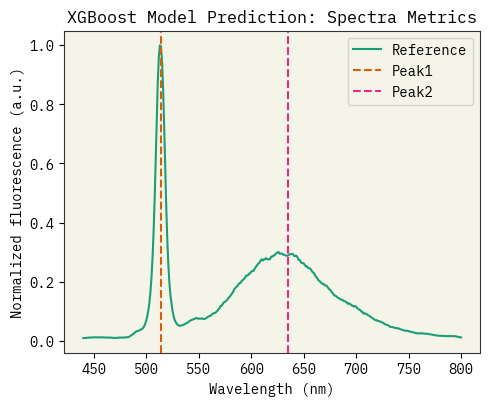

In [6]:
k = 0
sample = test_df.iloc[k:k+1]
feats = sample[features]
labs = sample[labels]

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

for k in labels:
    # print(k, rmse(models[k].predict(feats), labs[k].values))
    print(k, models[k].predict(feats), labs[k].values)

w = [float(a) for a in sample.iloc[0]['Fl_Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample.iloc[0]['Fluorescence_norm'][1:-1].split(',')]

# plt.figure(figsize=(6, 4))
plt.plot(w, i, color="C0", label="Reference")
# plt.title(f"{sample.iloc[0]['Experiment']}: {sample.iloc[0]['Temperature(C)']}°C, {sample.iloc[0]['Doping(%)']}%, {sample.iloc[0]['Time(min)']}min")
plt.title(f"XGBoost Model Prediction: Spectra Metrics")
plt.axvline(x = models['Peak1'].predict(sample[features]), color = 'C1', linestyle = '--', label = 'Peak1')
plt.axvline(x = models['Peak2'].predict(sample[features]), color = 'C3', linestyle = '--', label = 'Peak2')
# change plt figsize
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized fluorescence (a.u.)")
plt.tight_layout()
plt.legend()
plt.show()

## Spectra output

In [7]:
df = pd.read_csv('Data/fl_spectra_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

Dimension1(nm)  \
Experiment            Temperature(C) Doping(%) Time(min)                   
1_NPL-4_(5-31-22)     25             1.25      60                    361   
                                     2.50      60                    361   
                                     5.00      60                    361   
                                     10.00     60                    361   
2_NPL-4_(6-1-22)      25             0.25      60                    361   
                                     0.50      60                    361   
                                     0.75      60                    361   
                                     1.00      60                    361   
                                     1.25      60                    361   
                                     1.50      60                    361   
                                     1.75      60                    361   
                                     2.00      60                    361   
                                     3.00      60                    361   
3_NPL-11_(12-26-22)   25             0.50      60                    361   
                                     1.00      60                    361   
                                     2.00      60                    361   
                                     3.00      60                    361   
                                     5.00      60                    361   
4_NPL-17_(5-3-23)     25             0.50      60                    361   
                                     0.75      60                    361   
                                     1.00      60                    361   
                                     5.00      60                    361   
5_NPL-17_(5-22-23)    25             0.25      60                    361   
                                     0.50      60                    361   
                                     1.00      60                    361   
                                     5.00      60                    361   
6_NPL-6_C.L._(7-7-23) 25             0.50      60                    361   
                                     5.00      60                    361   
7_NPL-12_(3-8-23)     0              3.00      10                    361   
                                               60                    361   
                                     10.00     10                    361   
                                               60                    361   
                      25             3.00      10                    361   
                                               60                    361   
                                               180                   361   
                                     10.00     10                    361   
                                               60                    361   
                                               180                   361   
                      50             3.00      10                    361   
                                               60                    361   
                                     10.00     10                    361   
                                               60                    361   
8_NPL-13_(3-8-23)     0              1.00      10                    361   
                                               60                    361   
                                     5.00      10                    361   
                                               60                    361   
                      25             1.00      10                    361   
                                               60                    361   
                                               180                   361   
                                     5.00      10                    361   
                                               60                    361   
                              

In [8]:
index = df.keys().tolist().index('Experiment')
features = list(df.keys()[:index]) + ['Wavelength(nm)']
labels = ['Fluorescence_norm']
features, labels

(['Dimension1(nm)',
  'Dimension2(nm)',
  'Dilution(%)',
  'Nano_stock_vol(mL)',
  'Diluted_vol(mL)',
  'AgConc(M)',
  'AgMass(mg)',
  'MeOH_vol(mL)',
  'H2O_vol(mL)',
  'Doping(%)',
  'AgSol(uL)',
  'Time(min)',
  'Temperature(C)',
  'Wavelength(nm)'],
 ['Fluorescence_norm'])

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )
    
    X_train, y_train = train[train.columns.difference(['Fluorescence', 'Fluorescence_norm'])], train['Fluorescence_norm']
    X_test, y_test = test[test.columns.difference(['Fluorescence', 'Fluorescence_norm'])], test['Fluorescence_norm']
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

def test_model(model, validation):
    val_feats = validation[validation.columns.difference(['Fluorescence', 'Fluorescence_norm'])]
    val_labels = validation["Fluorescence_norm"]

    pred = model.predict(val_feats)
    return (pred, val_labels.to_numpy(), val_feats['Wavelength(nm)'].to_numpy())

In [10]:
one_out = []
i=0
for group, validation in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    data = df.copy()
    exp, T, d, t = group
    validation = validation[features + labels]

    # validation = data.query(
    #     f'`Temperature(C)` == {T} & `Doping(%)` == {d} & `Time` == {t}'
    # )
    train_df = data.drop(validation.index)
    train, test = train_test_split(train_df[features + labels], test_size=0.2, random_state=42)

    model = train_model(train, test)

    prediction = test_model(model, validation)
    one_out.append((group, prediction))


[0]	validation_0-rmse:0.31821	validation_0-mean_absolute_error:0.31098
[1]	validation_0-rmse:0.22560	validation_0-mean_absolute_error:0.22023
[2]	validation_0-rmse:0.16132	validation_0-mean_absolute_error:0.15689
[3]	validation_0-rmse:0.11694	validation_0-mean_absolute_error:0.11260
[4]	validation_0-rmse:0.08667	validation_0-mean_absolute_error:0.08161
[5]	validation_0-rmse:0.06615	validation_0-mean_absolute_error:0.05998
[6]	validation_0-rmse:0.05141	validation_0-mean_absolute_error:0.04427
[7]	validation_0-rmse:0.04123	validation_0-mean_absolute_error:0.03339
[8]	validation_0-rmse:0.03488	validation_0-mean_absolute_error:0.02609
[9]	validation_0-rmse:0.03059	validation_0-mean_absolute_error:0.02106
[10]	validation_0-rmse:0.02791	validation_0-mean_absolute_error:0.01748
[11]	validation_0-rmse:0.02557	validation_0-mean_absolute_error:0.01487
[12]	validation_0-rmse:0.02407	validation_0-mean_absolute_error:0.01309
[13]	validation_0-rmse:0.02346	validation_0-mean_absolute_error:0.01216
[1

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:0.01795	validation_0-mean_absolute_error:0.00821
[25]	validation_0-rmse:0.01737	validation_0-mean_absolute_error:0.00797
[26]	validation_0-rmse:0.01696	validation_0-mean_absolute_error:0.00776
[27]	validation_0-rmse:0.01665	validation_0-mean_absolute_error:0.00764
[28]	validation_0-rmse:0.01645	validation_0-mean_absolute_error:0.00753
[29]	validation_0-rmse:0.01638	validation_0-mean_absolute_error:0.00746
[30]	validation_0-rmse:0.01609	validation_0-mean_absolute_error:0.00732
[31]	validation_0-rmse:0.01599	validation_0-mean_absolute_error:0.00725
[32]	validation_0-rmse:0.01557	validation_0-mean_absolute_error:0.00707
[33]	validation_0-rmse:0.01537	validation_0-mean_absolute_error:0.00697
[34]	validation_0-rmse:0.01525	validation_0-mean_absolute_error:0.00690
[35]	validation_0-rmse:0.01493	validation_0-mean_absolute_error:0.00676
[36]	validation_0-rmse:0.01484	validation_0-mean_absolute_error:0.00671
[37]	validation_0-rmse:0.01475	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01483	validation_0-mean_absolute_error:0.00656
[36]	validation_0-rmse:0.01476	validation_0-mean_absolute_error:0.00648
[37]	validation_0-rmse:0.01432	validation_0-mean_absolute_error:0.00629
[38]	validation_0-rmse:0.01427	validation_0-mean_absolute_error:0.00623
[39]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00613
[40]	validation_0-rmse:0.01390	validation_0-mean_absolute_error:0.00605
[41]	validation_0-rmse:0.01382	validation_0-mean_absolute_error:0.00601
[42]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00589
[43]	validation_0-rmse:0.01339	validation_0-mean_absolute_error:0.00571
[44]	validation_0-rmse:0.01318	validation_0-mean_absolute_error:0.00562
[45]	validation_0-rmse:0.01309	validation_0-mean_absolute_error:0.00555
[46]	validation_0-rmse:0.01299	validation_0-mean_absolute_error:0.00543
[47]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00539
[48]	validation_0-rmse:0.01275	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00627
[37]	validation_0-rmse:0.01405	validation_0-mean_absolute_error:0.00613
[38]	validation_0-rmse:0.01396	validation_0-mean_absolute_error:0.00606
[39]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00600
[40]	validation_0-rmse:0.01371	validation_0-mean_absolute_error:0.00594
[41]	validation_0-rmse:0.01359	validation_0-mean_absolute_error:0.00590
[42]	validation_0-rmse:0.01344	validation_0-mean_absolute_error:0.00576
[43]	validation_0-rmse:0.01335	validation_0-mean_absolute_error:0.00566
[44]	validation_0-rmse:0.01323	validation_0-mean_absolute_error:0.00561
[45]	validation_0-rmse:0.01303	validation_0-mean_absolute_error:0.00556
[46]	validation_0-rmse:0.01296	validation_0-mean_absolute_error:0.00553
[47]	validation_0-rmse:0.01278	validation_0-mean_absolute_error:0.00546
[48]	validation_0-rmse:0.01267	validation_0-mean_absolute_error:0.00539
[49]	validation_0-rmse:0.01262	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.01451	validation_0-mean_absolute_error:0.00607
[40]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00593
[41]	validation_0-rmse:0.01406	validation_0-mean_absolute_error:0.00588
[42]	validation_0-rmse:0.01392	validation_0-mean_absolute_error:0.00582
[43]	validation_0-rmse:0.01382	validation_0-mean_absolute_error:0.00575
[44]	validation_0-rmse:0.01378	validation_0-mean_absolute_error:0.00570
[45]	validation_0-rmse:0.01365	validation_0-mean_absolute_error:0.00563
[46]	validation_0-rmse:0.01343	validation_0-mean_absolute_error:0.00555
[47]	validation_0-rmse:0.01337	validation_0-mean_absolute_error:0.00553
[48]	validation_0-rmse:0.01329	validation_0-mean_absolute_error:0.00549
[49]	validation_0-rmse:0.01302	validation_0-mean_absolute_error:0.00541
[50]	validation_0-rmse:0.01279	validation_0-mean_absolute_error:0.00533
[51]	validation_0-rmse:0.01271	validation_0-mean_absolute_error:0.00528
[52]	validation_0-rmse:0.01232	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01596	validation_0-mean_absolute_error:0.00694
[38]	validation_0-rmse:0.01574	validation_0-mean_absolute_error:0.00682
[39]	validation_0-rmse:0.01539	validation_0-mean_absolute_error:0.00670
[40]	validation_0-rmse:0.01530	validation_0-mean_absolute_error:0.00664
[41]	validation_0-rmse:0.01523	validation_0-mean_absolute_error:0.00656
[42]	validation_0-rmse:0.01509	validation_0-mean_absolute_error:0.00645
[43]	validation_0-rmse:0.01476	validation_0-mean_absolute_error:0.00639
[44]	validation_0-rmse:0.01443	validation_0-mean_absolute_error:0.00631
[45]	validation_0-rmse:0.01438	validation_0-mean_absolute_error:0.00621
[46]	validation_0-rmse:0.01435	validation_0-mean_absolute_error:0.00616
[47]	validation_0-rmse:0.01418	validation_0-mean_absolute_error:0.00606
[48]	validation_0-rmse:0.01399	validation_0-mean_absolute_error:0.00602
[49]	validation_0-rmse:0.01386	validation_0-mean_absolute_error:0.00595
[50]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01608	validation_0-mean_absolute_error:0.00718
[32]	validation_0-rmse:0.01603	validation_0-mean_absolute_error:0.00713
[33]	validation_0-rmse:0.01538	validation_0-mean_absolute_error:0.00693
[34]	validation_0-rmse:0.01521	validation_0-mean_absolute_error:0.00685
[35]	validation_0-rmse:0.01520	validation_0-mean_absolute_error:0.00682
[36]	validation_0-rmse:0.01500	validation_0-mean_absolute_error:0.00670
[37]	validation_0-rmse:0.01474	validation_0-mean_absolute_error:0.00663
[38]	validation_0-rmse:0.01452	validation_0-mean_absolute_error:0.00646
[39]	validation_0-rmse:0.01431	validation_0-mean_absolute_error:0.00634
[40]	validation_0-rmse:0.01420	validation_0-mean_absolute_error:0.00630
[41]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00626
[42]	validation_0-rmse:0.01404	validation_0-mean_absolute_error:0.00620
[43]	validation_0-rmse:0.01402	validation_0-mean_absolute_error:0.00618
[44]	validation_0-rmse:0.01399	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.01658	validation_0-mean_absolute_error:0.00720
[35]	validation_0-rmse:0.01595	validation_0-mean_absolute_error:0.00699
[36]	validation_0-rmse:0.01566	validation_0-mean_absolute_error:0.00684
[37]	validation_0-rmse:0.01550	validation_0-mean_absolute_error:0.00673
[38]	validation_0-rmse:0.01548	validation_0-mean_absolute_error:0.00668
[39]	validation_0-rmse:0.01515	validation_0-mean_absolute_error:0.00655
[40]	validation_0-rmse:0.01513	validation_0-mean_absolute_error:0.00651
[41]	validation_0-rmse:0.01510	validation_0-mean_absolute_error:0.00648
[42]	validation_0-rmse:0.01507	validation_0-mean_absolute_error:0.00642
[43]	validation_0-rmse:0.01496	validation_0-mean_absolute_error:0.00640
[44]	validation_0-rmse:0.01477	validation_0-mean_absolute_error:0.00630
[45]	validation_0-rmse:0.01471	validation_0-mean_absolute_error:0.00626
[46]	validation_0-rmse:0.01454	validation_0-mean_absolute_error:0.00617
[47]	validation_0-rmse:0.01423	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01467	validation_0-mean_absolute_error:0.00662
[38]	validation_0-rmse:0.01460	validation_0-mean_absolute_error:0.00654
[39]	validation_0-rmse:0.01445	validation_0-mean_absolute_error:0.00643
[40]	validation_0-rmse:0.01427	validation_0-mean_absolute_error:0.00634
[41]	validation_0-rmse:0.01417	validation_0-mean_absolute_error:0.00620
[42]	validation_0-rmse:0.01393	validation_0-mean_absolute_error:0.00608
[43]	validation_0-rmse:0.01392	validation_0-mean_absolute_error:0.00606
[44]	validation_0-rmse:0.01385	validation_0-mean_absolute_error:0.00596
[45]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00593
[46]	validation_0-rmse:0.01376	validation_0-mean_absolute_error:0.00589
[47]	validation_0-rmse:0.01366	validation_0-mean_absolute_error:0.00584
[48]	validation_0-rmse:0.01362	validation_0-mean_absolute_error:0.00579
[49]	validation_0-rmse:0.01354	validation_0-mean_absolute_error:0.00575
[50]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01483	validation_0-mean_absolute_error:0.00674
[38]	validation_0-rmse:0.01463	validation_0-mean_absolute_error:0.00661
[39]	validation_0-rmse:0.01446	validation_0-mean_absolute_error:0.00649
[40]	validation_0-rmse:0.01438	validation_0-mean_absolute_error:0.00646
[41]	validation_0-rmse:0.01433	validation_0-mean_absolute_error:0.00642
[42]	validation_0-rmse:0.01430	validation_0-mean_absolute_error:0.00638
[43]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00633
[44]	validation_0-rmse:0.01414	validation_0-mean_absolute_error:0.00624
[45]	validation_0-rmse:0.01406	validation_0-mean_absolute_error:0.00620
[46]	validation_0-rmse:0.01403	validation_0-mean_absolute_error:0.00616
[47]	validation_0-rmse:0.01402	validation_0-mean_absolute_error:0.00615
[48]	validation_0-rmse:0.01396	validation_0-mean_absolute_error:0.00610
[49]	validation_0-rmse:0.01386	validation_0-mean_absolute_error:0.00606
[50]	validation_0-rmse:0.01372	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01542	validation_0-mean_absolute_error:0.00677
[34]	validation_0-rmse:0.01510	validation_0-mean_absolute_error:0.00668
[35]	validation_0-rmse:0.01503	validation_0-mean_absolute_error:0.00663
[36]	validation_0-rmse:0.01489	validation_0-mean_absolute_error:0.00658
[37]	validation_0-rmse:0.01472	validation_0-mean_absolute_error:0.00649
[38]	validation_0-rmse:0.01462	validation_0-mean_absolute_error:0.00640
[39]	validation_0-rmse:0.01458	validation_0-mean_absolute_error:0.00637
[40]	validation_0-rmse:0.01435	validation_0-mean_absolute_error:0.00626
[41]	validation_0-rmse:0.01420	validation_0-mean_absolute_error:0.00617
[42]	validation_0-rmse:0.01410	validation_0-mean_absolute_error:0.00612
[43]	validation_0-rmse:0.01405	validation_0-mean_absolute_error:0.00608
[44]	validation_0-rmse:0.01388	validation_0-mean_absolute_error:0.00596
[45]	validation_0-rmse:0.01384	validation_0-mean_absolute_error:0.00594
[46]	validation_0-rmse:0.01377	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:0.01620	validation_0-mean_absolute_error:0.00747
[31]	validation_0-rmse:0.01609	validation_0-mean_absolute_error:0.00732
[32]	validation_0-rmse:0.01594	validation_0-mean_absolute_error:0.00725
[33]	validation_0-rmse:0.01571	validation_0-mean_absolute_error:0.00717
[34]	validation_0-rmse:0.01550	validation_0-mean_absolute_error:0.00707
[35]	validation_0-rmse:0.01530	validation_0-mean_absolute_error:0.00702
[36]	validation_0-rmse:0.01522	validation_0-mean_absolute_error:0.00691
[37]	validation_0-rmse:0.01516	validation_0-mean_absolute_error:0.00686
[38]	validation_0-rmse:0.01512	validation_0-mean_absolute_error:0.00681
[39]	validation_0-rmse:0.01506	validation_0-mean_absolute_error:0.00671
[40]	validation_0-rmse:0.01494	validation_0-mean_absolute_error:0.00667
[41]	validation_0-rmse:0.01486	validation_0-mean_absolute_error:0.00659
[42]	validation_0-rmse:0.01475	validation_0-mean_absolute_error:0.00654
[43]	validation_0-rmse:0.01470	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:0.01664	validation_0-mean_absolute_error:0.00749
[28]	validation_0-rmse:0.01634	validation_0-mean_absolute_error:0.00734
[29]	validation_0-rmse:0.01629	validation_0-mean_absolute_error:0.00728
[30]	validation_0-rmse:0.01598	validation_0-mean_absolute_error:0.00716
[31]	validation_0-rmse:0.01570	validation_0-mean_absolute_error:0.00701
[32]	validation_0-rmse:0.01563	validation_0-mean_absolute_error:0.00694
[33]	validation_0-rmse:0.01557	validation_0-mean_absolute_error:0.00688
[34]	validation_0-rmse:0.01534	validation_0-mean_absolute_error:0.00676
[35]	validation_0-rmse:0.01526	validation_0-mean_absolute_error:0.00668
[36]	validation_0-rmse:0.01490	validation_0-mean_absolute_error:0.00650
[37]	validation_0-rmse:0.01477	validation_0-mean_absolute_error:0.00643
[38]	validation_0-rmse:0.01472	validation_0-mean_absolute_error:0.00640
[39]	validation_0-rmse:0.01460	validation_0-mean_absolute_error:0.00632
[40]	validation_0-rmse:0.01451	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:0.01678	validation_0-mean_absolute_error:0.00781
[30]	validation_0-rmse:0.01660	validation_0-mean_absolute_error:0.00763
[31]	validation_0-rmse:0.01617	validation_0-mean_absolute_error:0.00743
[32]	validation_0-rmse:0.01597	validation_0-mean_absolute_error:0.00732
[33]	validation_0-rmse:0.01567	validation_0-mean_absolute_error:0.00720
[34]	validation_0-rmse:0.01550	validation_0-mean_absolute_error:0.00713
[35]	validation_0-rmse:0.01536	validation_0-mean_absolute_error:0.00707
[36]	validation_0-rmse:0.01505	validation_0-mean_absolute_error:0.00692
[37]	validation_0-rmse:0.01499	validation_0-mean_absolute_error:0.00682
[38]	validation_0-rmse:0.01497	validation_0-mean_absolute_error:0.00679
[39]	validation_0-rmse:0.01493	validation_0-mean_absolute_error:0.00673
[40]	validation_0-rmse:0.01484	validation_0-mean_absolute_error:0.00667
[41]	validation_0-rmse:0.01458	validation_0-mean_absolute_error:0.00658
[42]	validation_0-rmse:0.01429	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:0.01683	validation_0-mean_absolute_error:0.00752
[28]	validation_0-rmse:0.01662	validation_0-mean_absolute_error:0.00738
[29]	validation_0-rmse:0.01642	validation_0-mean_absolute_error:0.00715
[30]	validation_0-rmse:0.01625	validation_0-mean_absolute_error:0.00701
[31]	validation_0-rmse:0.01616	validation_0-mean_absolute_error:0.00692
[32]	validation_0-rmse:0.01554	validation_0-mean_absolute_error:0.00670
[33]	validation_0-rmse:0.01549	validation_0-mean_absolute_error:0.00664
[34]	validation_0-rmse:0.01482	validation_0-mean_absolute_error:0.00644
[35]	validation_0-rmse:0.01467	validation_0-mean_absolute_error:0.00637
[36]	validation_0-rmse:0.01464	validation_0-mean_absolute_error:0.00630
[37]	validation_0-rmse:0.01445	validation_0-mean_absolute_error:0.00621
[38]	validation_0-rmse:0.01437	validation_0-mean_absolute_error:0.00614
[39]	validation_0-rmse:0.01397	validation_0-mean_absolute_error:0.00603
[40]	validation_0-rmse:0.01390	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:0.01756	validation_0-mean_absolute_error:0.00833
[25]	validation_0-rmse:0.01742	validation_0-mean_absolute_error:0.00824
[26]	validation_0-rmse:0.01669	validation_0-mean_absolute_error:0.00798
[27]	validation_0-rmse:0.01620	validation_0-mean_absolute_error:0.00781
[28]	validation_0-rmse:0.01607	validation_0-mean_absolute_error:0.00765
[29]	validation_0-rmse:0.01599	validation_0-mean_absolute_error:0.00757
[30]	validation_0-rmse:0.01569	validation_0-mean_absolute_error:0.00742
[31]	validation_0-rmse:0.01562	validation_0-mean_absolute_error:0.00736
[32]	validation_0-rmse:0.01541	validation_0-mean_absolute_error:0.00722
[33]	validation_0-rmse:0.01539	validation_0-mean_absolute_error:0.00719
[34]	validation_0-rmse:0.01500	validation_0-mean_absolute_error:0.00698
[35]	validation_0-rmse:0.01494	validation_0-mean_absolute_error:0.00692
[36]	validation_0-rmse:0.01473	validation_0-mean_absolute_error:0.00675
[37]	validation_0-rmse:0.01460	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:0.01476	validation_0-mean_absolute_error:0.00633
[39]	validation_0-rmse:0.01450	validation_0-mean_absolute_error:0.00620
[40]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00605
[41]	validation_0-rmse:0.01421	validation_0-mean_absolute_error:0.00598
[42]	validation_0-rmse:0.01416	validation_0-mean_absolute_error:0.00593
[43]	validation_0-rmse:0.01409	validation_0-mean_absolute_error:0.00589
[44]	validation_0-rmse:0.01383	validation_0-mean_absolute_error:0.00580
[45]	validation_0-rmse:0.01375	validation_0-mean_absolute_error:0.00573
[46]	validation_0-rmse:0.01372	validation_0-mean_absolute_error:0.00569
[47]	validation_0-rmse:0.01359	validation_0-mean_absolute_error:0.00560
[48]	validation_0-rmse:0.01356	validation_0-mean_absolute_error:0.00554
[49]	validation_0-rmse:0.01354	validation_0-mean_absolute_error:0.00552
[50]	validation_0-rmse:0.01336	validation_0-mean_absolute_error:0.00546
[51]	validation_0-rmse:0.01322	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01485	validation_0-mean_absolute_error:0.00690
[32]	validation_0-rmse:0.01471	validation_0-mean_absolute_error:0.00678
[33]	validation_0-rmse:0.01456	validation_0-mean_absolute_error:0.00669
[34]	validation_0-rmse:0.01447	validation_0-mean_absolute_error:0.00657
[35]	validation_0-rmse:0.01437	validation_0-mean_absolute_error:0.00649
[36]	validation_0-rmse:0.01428	validation_0-mean_absolute_error:0.00634
[37]	validation_0-rmse:0.01420	validation_0-mean_absolute_error:0.00628
[38]	validation_0-rmse:0.01411	validation_0-mean_absolute_error:0.00619
[39]	validation_0-rmse:0.01404	validation_0-mean_absolute_error:0.00613
[40]	validation_0-rmse:0.01377	validation_0-mean_absolute_error:0.00605
[41]	validation_0-rmse:0.01365	validation_0-mean_absolute_error:0.00601
[42]	validation_0-rmse:0.01337	validation_0-mean_absolute_error:0.00595
[43]	validation_0-rmse:0.01328	validation_0-mean_absolute_error:0.00588
[44]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:0.01367	validation_0-mean_absolute_error:0.00617
[42]	validation_0-rmse:0.01356	validation_0-mean_absolute_error:0.00607
[43]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00594
[44]	validation_0-rmse:0.01338	validation_0-mean_absolute_error:0.00584
[45]	validation_0-rmse:0.01306	validation_0-mean_absolute_error:0.00576
[46]	validation_0-rmse:0.01293	validation_0-mean_absolute_error:0.00571
[47]	validation_0-rmse:0.01280	validation_0-mean_absolute_error:0.00565
[48]	validation_0-rmse:0.01264	validation_0-mean_absolute_error:0.00556
[49]	validation_0-rmse:0.01254	validation_0-mean_absolute_error:0.00547
[50]	validation_0-rmse:0.01247	validation_0-mean_absolute_error:0.00544
[51]	validation_0-rmse:0.01242	validation_0-mean_absolute_error:0.00541
[52]	validation_0-rmse:0.01238	validation_0-mean_absolute_error:0.00537
[53]	validation_0-rmse:0.01232	validation_0-mean_absolute_error:0.00531
[54]	validation_0-rmse:0.01219	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.01589	validation_0-mean_absolute_error:0.00707
[33]	validation_0-rmse:0.01523	validation_0-mean_absolute_error:0.00686
[34]	validation_0-rmse:0.01492	validation_0-mean_absolute_error:0.00671
[35]	validation_0-rmse:0.01477	validation_0-mean_absolute_error:0.00658
[36]	validation_0-rmse:0.01470	validation_0-mean_absolute_error:0.00647
[37]	validation_0-rmse:0.01441	validation_0-mean_absolute_error:0.00634
[38]	validation_0-rmse:0.01435	validation_0-mean_absolute_error:0.00631
[39]	validation_0-rmse:0.01425	validation_0-mean_absolute_error:0.00625
[40]	validation_0-rmse:0.01410	validation_0-mean_absolute_error:0.00617
[41]	validation_0-rmse:0.01385	validation_0-mean_absolute_error:0.00606
[42]	validation_0-rmse:0.01375	validation_0-mean_absolute_error:0.00601
[43]	validation_0-rmse:0.01351	validation_0-mean_absolute_error:0.00587
[44]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00583
[45]	validation_0-rmse:0.01337	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01424	validation_0-mean_absolute_error:0.00642
[38]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00631
[39]	validation_0-rmse:0.01392	validation_0-mean_absolute_error:0.00622
[40]	validation_0-rmse:0.01389	validation_0-mean_absolute_error:0.00617
[41]	validation_0-rmse:0.01377	validation_0-mean_absolute_error:0.00605
[42]	validation_0-rmse:0.01362	validation_0-mean_absolute_error:0.00598
[43]	validation_0-rmse:0.01354	validation_0-mean_absolute_error:0.00594
[44]	validation_0-rmse:0.01340	validation_0-mean_absolute_error:0.00588
[45]	validation_0-rmse:0.01326	validation_0-mean_absolute_error:0.00580
[46]	validation_0-rmse:0.01315	validation_0-mean_absolute_error:0.00571
[47]	validation_0-rmse:0.01293	validation_0-mean_absolute_error:0.00561
[48]	validation_0-rmse:0.01280	validation_0-mean_absolute_error:0.00555
[49]	validation_0-rmse:0.01271	validation_0-mean_absolute_error:0.00548
[50]	validation_0-rmse:0.01269	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.01478	validation_0-mean_absolute_error:0.00683
[33]	validation_0-rmse:0.01462	validation_0-mean_absolute_error:0.00674
[34]	validation_0-rmse:0.01444	validation_0-mean_absolute_error:0.00666
[35]	validation_0-rmse:0.01430	validation_0-mean_absolute_error:0.00650
[36]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00641
[37]	validation_0-rmse:0.01394	validation_0-mean_absolute_error:0.00630
[38]	validation_0-rmse:0.01388	validation_0-mean_absolute_error:0.00624
[39]	validation_0-rmse:0.01372	validation_0-mean_absolute_error:0.00604
[40]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00591
[41]	validation_0-rmse:0.01341	validation_0-mean_absolute_error:0.00586
[42]	validation_0-rmse:0.01331	validation_0-mean_absolute_error:0.00576
[43]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:0.00570
[44]	validation_0-rmse:0.01309	validation_0-mean_absolute_error:0.00562
[45]	validation_0-rmse:0.01297	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01285	validation_0-mean_absolute_error:0.00592
[36]	validation_0-rmse:0.01268	validation_0-mean_absolute_error:0.00582
[37]	validation_0-rmse:0.01256	validation_0-mean_absolute_error:0.00570
[38]	validation_0-rmse:0.01239	validation_0-mean_absolute_error:0.00562
[39]	validation_0-rmse:0.01228	validation_0-mean_absolute_error:0.00557
[40]	validation_0-rmse:0.01212	validation_0-mean_absolute_error:0.00547
[41]	validation_0-rmse:0.01204	validation_0-mean_absolute_error:0.00543
[42]	validation_0-rmse:0.01193	validation_0-mean_absolute_error:0.00538
[43]	validation_0-rmse:0.01190	validation_0-mean_absolute_error:0.00536
[44]	validation_0-rmse:0.01187	validation_0-mean_absolute_error:0.00534
[45]	validation_0-rmse:0.01179	validation_0-mean_absolute_error:0.00526
[46]	validation_0-rmse:0.01176	validation_0-mean_absolute_error:0.00522
[47]	validation_0-rmse:0.01171	validation_0-mean_absolute_error:0.00517
[48]	validation_0-rmse:0.01163	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.01596	validation_0-mean_absolute_error:0.00625
[40]	validation_0-rmse:0.01581	validation_0-mean_absolute_error:0.00617
[41]	validation_0-rmse:0.01544	validation_0-mean_absolute_error:0.00610
[42]	validation_0-rmse:0.01537	validation_0-mean_absolute_error:0.00601
[43]	validation_0-rmse:0.01509	validation_0-mean_absolute_error:0.00596
[44]	validation_0-rmse:0.01481	validation_0-mean_absolute_error:0.00588
[45]	validation_0-rmse:0.01481	validation_0-mean_absolute_error:0.00584
[46]	validation_0-rmse:0.01472	validation_0-mean_absolute_error:0.00576
[47]	validation_0-rmse:0.01468	validation_0-mean_absolute_error:0.00572
[48]	validation_0-rmse:0.01465	validation_0-mean_absolute_error:0.00570
[49]	validation_0-rmse:0.01457	validation_0-mean_absolute_error:0.00568
[50]	validation_0-rmse:0.01444	validation_0-mean_absolute_error:0.00563
[51]	validation_0-rmse:0.01442	validation_0-mean_absolute_error:0.00559
[52]	validation_0-rmse:0.01429	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.01428	validation_0-mean_absolute_error:0.00621
[41]	validation_0-rmse:0.01413	validation_0-mean_absolute_error:0.00613
[42]	validation_0-rmse:0.01408	validation_0-mean_absolute_error:0.00605
[43]	validation_0-rmse:0.01379	validation_0-mean_absolute_error:0.00595
[44]	validation_0-rmse:0.01371	validation_0-mean_absolute_error:0.00585
[45]	validation_0-rmse:0.01361	validation_0-mean_absolute_error:0.00582
[46]	validation_0-rmse:0.01351	validation_0-mean_absolute_error:0.00574
[47]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00570
[48]	validation_0-rmse:0.01324	validation_0-mean_absolute_error:0.00558
[49]	validation_0-rmse:0.01304	validation_0-mean_absolute_error:0.00546
[50]	validation_0-rmse:0.01292	validation_0-mean_absolute_error:0.00539
[51]	validation_0-rmse:0.01286	validation_0-mean_absolute_error:0.00536
[52]	validation_0-rmse:0.01281	validation_0-mean_absolute_error:0.00534
[53]	validation_0-rmse:0.01273	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.01434	validation_0-mean_absolute_error:0.00592
[40]	validation_0-rmse:0.01418	validation_0-mean_absolute_error:0.00585
[41]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00579
[42]	validation_0-rmse:0.01404	validation_0-mean_absolute_error:0.00573
[43]	validation_0-rmse:0.01401	validation_0-mean_absolute_error:0.00569
[44]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00562
[45]	validation_0-rmse:0.01355	validation_0-mean_absolute_error:0.00554
[46]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:0.00549
[47]	validation_0-rmse:0.01342	validation_0-mean_absolute_error:0.00540
[48]	validation_0-rmse:0.01340	validation_0-mean_absolute_error:0.00538
[49]	validation_0-rmse:0.01319	validation_0-mean_absolute_error:0.00531
[50]	validation_0-rmse:0.01307	validation_0-mean_absolute_error:0.00525
[51]	validation_0-rmse:0.01305	validation_0-mean_absolute_error:0.00522
[52]	validation_0-rmse:0.01290	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.01443	validation_0-mean_absolute_error:0.00640
[35]	validation_0-rmse:0.01442	validation_0-mean_absolute_error:0.00638
[36]	validation_0-rmse:0.01434	validation_0-mean_absolute_error:0.00632
[37]	validation_0-rmse:0.01411	validation_0-mean_absolute_error:0.00619
[38]	validation_0-rmse:0.01396	validation_0-mean_absolute_error:0.00610
[39]	validation_0-rmse:0.01387	validation_0-mean_absolute_error:0.00602
[40]	validation_0-rmse:0.01364	validation_0-mean_absolute_error:0.00592
[41]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00591
[42]	validation_0-rmse:0.01346	validation_0-mean_absolute_error:0.00585
[43]	validation_0-rmse:0.01325	validation_0-mean_absolute_error:0.00579
[44]	validation_0-rmse:0.01318	validation_0-mean_absolute_error:0.00575
[45]	validation_0-rmse:0.01303	validation_0-mean_absolute_error:0.00567
[46]	validation_0-rmse:0.01292	validation_0-mean_absolute_error:0.00562
[47]	validation_0-rmse:0.01283	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.01218	validation_0-mean_absolute_error:0.00553
[41]	validation_0-rmse:0.01212	validation_0-mean_absolute_error:0.00548
[42]	validation_0-rmse:0.01200	validation_0-mean_absolute_error:0.00541
[43]	validation_0-rmse:0.01192	validation_0-mean_absolute_error:0.00538
[44]	validation_0-rmse:0.01185	validation_0-mean_absolute_error:0.00532
[45]	validation_0-rmse:0.01172	validation_0-mean_absolute_error:0.00524
[46]	validation_0-rmse:0.01159	validation_0-mean_absolute_error:0.00519
[47]	validation_0-rmse:0.01105	validation_0-mean_absolute_error:0.00505
[48]	validation_0-rmse:0.01103	validation_0-mean_absolute_error:0.00502
[49]	validation_0-rmse:0.01077	validation_0-mean_absolute_error:0.00495
[50]	validation_0-rmse:0.01074	validation_0-mean_absolute_error:0.00492
[51]	validation_0-rmse:0.01066	validation_0-mean_absolute_error:0.00488
[52]	validation_0-rmse:0.01041	validation_0-mean_absolute_error:0.00479
[53]	validation_0-rmse:0.01036	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01555	validation_0-mean_absolute_error:0.00658
[34]	validation_0-rmse:0.01542	validation_0-mean_absolute_error:0.00652
[35]	validation_0-rmse:0.01537	validation_0-mean_absolute_error:0.00644
[36]	validation_0-rmse:0.01531	validation_0-mean_absolute_error:0.00634
[37]	validation_0-rmse:0.01454	validation_0-mean_absolute_error:0.00623
[38]	validation_0-rmse:0.01443	validation_0-mean_absolute_error:0.00610
[39]	validation_0-rmse:0.01370	validation_0-mean_absolute_error:0.00595
[40]	validation_0-rmse:0.01361	validation_0-mean_absolute_error:0.00586
[41]	validation_0-rmse:0.01354	validation_0-mean_absolute_error:0.00583
[42]	validation_0-rmse:0.01343	validation_0-mean_absolute_error:0.00576
[43]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00567
[44]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:0.00558
[45]	validation_0-rmse:0.01298	validation_0-mean_absolute_error:0.00550
[46]	validation_0-rmse:0.01290	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01474	validation_0-mean_absolute_error:0.00650
[36]	validation_0-rmse:0.01454	validation_0-mean_absolute_error:0.00638
[37]	validation_0-rmse:0.01445	validation_0-mean_absolute_error:0.00630
[38]	validation_0-rmse:0.01439	validation_0-mean_absolute_error:0.00622
[39]	validation_0-rmse:0.01424	validation_0-mean_absolute_error:0.00612
[40]	validation_0-rmse:0.01416	validation_0-mean_absolute_error:0.00608
[41]	validation_0-rmse:0.01400	validation_0-mean_absolute_error:0.00603
[42]	validation_0-rmse:0.01378	validation_0-mean_absolute_error:0.00593
[43]	validation_0-rmse:0.01369	validation_0-mean_absolute_error:0.00588
[44]	validation_0-rmse:0.01353	validation_0-mean_absolute_error:0.00580
[45]	validation_0-rmse:0.01349	validation_0-mean_absolute_error:0.00579
[46]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00576
[47]	validation_0-rmse:0.01339	validation_0-mean_absolute_error:0.00571
[48]	validation_0-rmse:0.01325	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.01409	validation_0-mean_absolute_error:0.00668
[35]	validation_0-rmse:0.01405	validation_0-mean_absolute_error:0.00662
[36]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00648
[37]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:0.00635
[38]	validation_0-rmse:0.01344	validation_0-mean_absolute_error:0.00630
[39]	validation_0-rmse:0.01325	validation_0-mean_absolute_error:0.00618
[40]	validation_0-rmse:0.01275	validation_0-mean_absolute_error:0.00603
[41]	validation_0-rmse:0.01258	validation_0-mean_absolute_error:0.00592
[42]	validation_0-rmse:0.01242	validation_0-mean_absolute_error:0.00585
[43]	validation_0-rmse:0.01236	validation_0-mean_absolute_error:0.00577
[44]	validation_0-rmse:0.01209	validation_0-mean_absolute_error:0.00565
[45]	validation_0-rmse:0.01207	validation_0-mean_absolute_error:0.00562
[46]	validation_0-rmse:0.01200	validation_0-mean_absolute_error:0.00559
[47]	validation_0-rmse:0.01196	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.01437	validation_0-mean_absolute_error:0.00654
[35]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00645
[36]	validation_0-rmse:0.01413	validation_0-mean_absolute_error:0.00637
[37]	validation_0-rmse:0.01400	validation_0-mean_absolute_error:0.00630
[38]	validation_0-rmse:0.01393	validation_0-mean_absolute_error:0.00622
[39]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00618
[40]	validation_0-rmse:0.01378	validation_0-mean_absolute_error:0.00615
[41]	validation_0-rmse:0.01369	validation_0-mean_absolute_error:0.00612
[42]	validation_0-rmse:0.01364	validation_0-mean_absolute_error:0.00605
[43]	validation_0-rmse:0.01311	validation_0-mean_absolute_error:0.00596
[44]	validation_0-rmse:0.01286	validation_0-mean_absolute_error:0.00583
[45]	validation_0-rmse:0.01276	validation_0-mean_absolute_error:0.00576
[46]	validation_0-rmse:0.01264	validation_0-mean_absolute_error:0.00567
[47]	validation_0-rmse:0.01257	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.01446	validation_0-mean_absolute_error:0.00675
[33]	validation_0-rmse:0.01432	validation_0-mean_absolute_error:0.00663
[34]	validation_0-rmse:0.01418	validation_0-mean_absolute_error:0.00649
[35]	validation_0-rmse:0.01406	validation_0-mean_absolute_error:0.00639
[36]	validation_0-rmse:0.01397	validation_0-mean_absolute_error:0.00624
[37]	validation_0-rmse:0.01390	validation_0-mean_absolute_error:0.00618
[38]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00612
[39]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:0.00600
[40]	validation_0-rmse:0.01337	validation_0-mean_absolute_error:0.00594
[41]	validation_0-rmse:0.01302	validation_0-mean_absolute_error:0.00583
[42]	validation_0-rmse:0.01290	validation_0-mean_absolute_error:0.00577
[43]	validation_0-rmse:0.01286	validation_0-mean_absolute_error:0.00573
[44]	validation_0-rmse:0.01274	validation_0-mean_absolute_error:0.00566
[45]	validation_0-rmse:0.01263	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01484	validation_0-mean_absolute_error:0.00682
[34]	validation_0-rmse:0.01460	validation_0-mean_absolute_error:0.00671
[35]	validation_0-rmse:0.01445	validation_0-mean_absolute_error:0.00662
[36]	validation_0-rmse:0.01435	validation_0-mean_absolute_error:0.00651
[37]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00645
[38]	validation_0-rmse:0.01420	validation_0-mean_absolute_error:0.00639
[39]	validation_0-rmse:0.01414	validation_0-mean_absolute_error:0.00637
[40]	validation_0-rmse:0.01405	validation_0-mean_absolute_error:0.00630
[41]	validation_0-rmse:0.01393	validation_0-mean_absolute_error:0.00624
[42]	validation_0-rmse:0.01387	validation_0-mean_absolute_error:0.00618
[43]	validation_0-rmse:0.01379	validation_0-mean_absolute_error:0.00610
[44]	validation_0-rmse:0.01373	validation_0-mean_absolute_error:0.00604
[45]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00596
[46]	validation_0-rmse:0.01323	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01459	validation_0-mean_absolute_error:0.00701
[32]	validation_0-rmse:0.01447	validation_0-mean_absolute_error:0.00691
[33]	validation_0-rmse:0.01391	validation_0-mean_absolute_error:0.00673
[34]	validation_0-rmse:0.01373	validation_0-mean_absolute_error:0.00661
[35]	validation_0-rmse:0.01359	validation_0-mean_absolute_error:0.00642
[36]	validation_0-rmse:0.01353	validation_0-mean_absolute_error:0.00637
[37]	validation_0-rmse:0.01340	validation_0-mean_absolute_error:0.00619
[38]	validation_0-rmse:0.01334	validation_0-mean_absolute_error:0.00616
[39]	validation_0-rmse:0.01329	validation_0-mean_absolute_error:0.00611
[40]	validation_0-rmse:0.01304	validation_0-mean_absolute_error:0.00598
[41]	validation_0-rmse:0.01298	validation_0-mean_absolute_error:0.00592
[42]	validation_0-rmse:0.01291	validation_0-mean_absolute_error:0.00583
[43]	validation_0-rmse:0.01260	validation_0-mean_absolute_error:0.00576
[44]	validation_0-rmse:0.01235	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:0.01508	validation_0-mean_absolute_error:0.00711
[28]	validation_0-rmse:0.01458	validation_0-mean_absolute_error:0.00698
[29]	validation_0-rmse:0.01449	validation_0-mean_absolute_error:0.00689
[30]	validation_0-rmse:0.01433	validation_0-mean_absolute_error:0.00681
[31]	validation_0-rmse:0.01428	validation_0-mean_absolute_error:0.00674
[32]	validation_0-rmse:0.01424	validation_0-mean_absolute_error:0.00669
[33]	validation_0-rmse:0.01403	validation_0-mean_absolute_error:0.00662
[34]	validation_0-rmse:0.01398	validation_0-mean_absolute_error:0.00655
[35]	validation_0-rmse:0.01357	validation_0-mean_absolute_error:0.00644
[36]	validation_0-rmse:0.01346	validation_0-mean_absolute_error:0.00631
[37]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00624
[38]	validation_0-rmse:0.01316	validation_0-mean_absolute_error:0.00610
[39]	validation_0-rmse:0.01311	validation_0-mean_absolute_error:0.00602
[40]	validation_0-rmse:0.01286	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01484	validation_0-mean_absolute_error:0.00677
[34]	validation_0-rmse:0.01467	validation_0-mean_absolute_error:0.00666
[35]	validation_0-rmse:0.01435	validation_0-mean_absolute_error:0.00651
[36]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00644
[37]	validation_0-rmse:0.01415	validation_0-mean_absolute_error:0.00636
[38]	validation_0-rmse:0.01410	validation_0-mean_absolute_error:0.00629
[39]	validation_0-rmse:0.01403	validation_0-mean_absolute_error:0.00621
[40]	validation_0-rmse:0.01349	validation_0-mean_absolute_error:0.00605
[41]	validation_0-rmse:0.01337	validation_0-mean_absolute_error:0.00598
[42]	validation_0-rmse:0.01314	validation_0-mean_absolute_error:0.00591
[43]	validation_0-rmse:0.01303	validation_0-mean_absolute_error:0.00581
[44]	validation_0-rmse:0.01296	validation_0-mean_absolute_error:0.00578
[45]	validation_0-rmse:0.01288	validation_0-mean_absolute_error:0.00573
[46]	validation_0-rmse:0.01287	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00670
[35]	validation_0-rmse:0.01362	validation_0-mean_absolute_error:0.00655
[36]	validation_0-rmse:0.01357	validation_0-mean_absolute_error:0.00649
[37]	validation_0-rmse:0.01346	validation_0-mean_absolute_error:0.00645
[38]	validation_0-rmse:0.01342	validation_0-mean_absolute_error:0.00643
[39]	validation_0-rmse:0.01335	validation_0-mean_absolute_error:0.00640
[40]	validation_0-rmse:0.01326	validation_0-mean_absolute_error:0.00628
[41]	validation_0-rmse:0.01314	validation_0-mean_absolute_error:0.00615
[42]	validation_0-rmse:0.01288	validation_0-mean_absolute_error:0.00602
[43]	validation_0-rmse:0.01284	validation_0-mean_absolute_error:0.00595
[44]	validation_0-rmse:0.01277	validation_0-mean_absolute_error:0.00591
[45]	validation_0-rmse:0.01258	validation_0-mean_absolute_error:0.00581
[46]	validation_0-rmse:0.01252	validation_0-mean_absolute_error:0.00577
[47]	validation_0-rmse:0.01235	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01397	validation_0-mean_absolute_error:0.00677
[32]	validation_0-rmse:0.01388	validation_0-mean_absolute_error:0.00670
[33]	validation_0-rmse:0.01385	validation_0-mean_absolute_error:0.00667
[34]	validation_0-rmse:0.01380	validation_0-mean_absolute_error:0.00664
[35]	validation_0-rmse:0.01352	validation_0-mean_absolute_error:0.00651
[36]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:0.00649
[37]	validation_0-rmse:0.01339	validation_0-mean_absolute_error:0.00640
[38]	validation_0-rmse:0.01334	validation_0-mean_absolute_error:0.00638
[39]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00636
[40]	validation_0-rmse:0.01322	validation_0-mean_absolute_error:0.00628
[41]	validation_0-rmse:0.01305	validation_0-mean_absolute_error:0.00616
[42]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00606
[43]	validation_0-rmse:0.01274	validation_0-mean_absolute_error:0.00601
[44]	validation_0-rmse:0.01269	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01409	validation_0-mean_absolute_error:0.00662
[34]	validation_0-rmse:0.01389	validation_0-mean_absolute_error:0.00652
[35]	validation_0-rmse:0.01372	validation_0-mean_absolute_error:0.00644
[36]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00640
[37]	validation_0-rmse:0.01350	validation_0-mean_absolute_error:0.00630
[38]	validation_0-rmse:0.01338	validation_0-mean_absolute_error:0.00625
[39]	validation_0-rmse:0.01313	validation_0-mean_absolute_error:0.00612
[40]	validation_0-rmse:0.01307	validation_0-mean_absolute_error:0.00608
[41]	validation_0-rmse:0.01293	validation_0-mean_absolute_error:0.00595
[42]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00583
[43]	validation_0-rmse:0.01259	validation_0-mean_absolute_error:0.00576
[44]	validation_0-rmse:0.01253	validation_0-mean_absolute_error:0.00570
[45]	validation_0-rmse:0.01228	validation_0-mean_absolute_error:0.00560
[46]	validation_0-rmse:0.01221	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01466	validation_0-mean_absolute_error:0.00682
[34]	validation_0-rmse:0.01450	validation_0-mean_absolute_error:0.00668
[35]	validation_0-rmse:0.01414	validation_0-mean_absolute_error:0.00657
[36]	validation_0-rmse:0.01406	validation_0-mean_absolute_error:0.00651
[37]	validation_0-rmse:0.01383	validation_0-mean_absolute_error:0.00640
[38]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00630
[39]	validation_0-rmse:0.01358	validation_0-mean_absolute_error:0.00625
[40]	validation_0-rmse:0.01352	validation_0-mean_absolute_error:0.00616
[41]	validation_0-rmse:0.01319	validation_0-mean_absolute_error:0.00604
[42]	validation_0-rmse:0.01308	validation_0-mean_absolute_error:0.00592
[43]	validation_0-rmse:0.01295	validation_0-mean_absolute_error:0.00583
[44]	validation_0-rmse:0.01287	validation_0-mean_absolute_error:0.00574
[45]	validation_0-rmse:0.01279	validation_0-mean_absolute_error:0.00565
[46]	validation_0-rmse:0.01266	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.01438	validation_0-mean_absolute_error:0.00667
[33]	validation_0-rmse:0.01430	validation_0-mean_absolute_error:0.00660
[34]	validation_0-rmse:0.01410	validation_0-mean_absolute_error:0.00653
[35]	validation_0-rmse:0.01394	validation_0-mean_absolute_error:0.00639
[36]	validation_0-rmse:0.01374	validation_0-mean_absolute_error:0.00629
[37]	validation_0-rmse:0.01371	validation_0-mean_absolute_error:0.00625
[38]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00617
[39]	validation_0-rmse:0.01352	validation_0-mean_absolute_error:0.00608
[40]	validation_0-rmse:0.01338	validation_0-mean_absolute_error:0.00605
[41]	validation_0-rmse:0.01309	validation_0-mean_absolute_error:0.00593
[42]	validation_0-rmse:0.01299	validation_0-mean_absolute_error:0.00589
[43]	validation_0-rmse:0.01296	validation_0-mean_absolute_error:0.00588
[44]	validation_0-rmse:0.01289	validation_0-mean_absolute_error:0.00581
[45]	validation_0-rmse:0.01270	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.01357	validation_0-mean_absolute_error:0.00616
[40]	validation_0-rmse:0.01356	validation_0-mean_absolute_error:0.00614
[41]	validation_0-rmse:0.01343	validation_0-mean_absolute_error:0.00608
[42]	validation_0-rmse:0.01336	validation_0-mean_absolute_error:0.00604
[43]	validation_0-rmse:0.01298	validation_0-mean_absolute_error:0.00592
[44]	validation_0-rmse:0.01292	validation_0-mean_absolute_error:0.00589
[45]	validation_0-rmse:0.01291	validation_0-mean_absolute_error:0.00585
[46]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00579
[47]	validation_0-rmse:0.01273	validation_0-mean_absolute_error:0.00576
[48]	validation_0-rmse:0.01272	validation_0-mean_absolute_error:0.00575
[49]	validation_0-rmse:0.01255	validation_0-mean_absolute_error:0.00565
[50]	validation_0-rmse:0.01253	validation_0-mean_absolute_error:0.00562
[51]	validation_0-rmse:0.01243	validation_0-mean_absolute_error:0.00551
[52]	validation_0-rmse:0.01239	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-rmse:0.01403	validation_0-mean_absolute_error:0.00637
[37]	validation_0-rmse:0.01390	validation_0-mean_absolute_error:0.00627
[38]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00613
[39]	validation_0-rmse:0.01355	validation_0-mean_absolute_error:0.00609
[40]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00603
[41]	validation_0-rmse:0.01329	validation_0-mean_absolute_error:0.00595
[42]	validation_0-rmse:0.01314	validation_0-mean_absolute_error:0.00588
[43]	validation_0-rmse:0.01307	validation_0-mean_absolute_error:0.00581
[44]	validation_0-rmse:0.01294	validation_0-mean_absolute_error:0.00574
[45]	validation_0-rmse:0.01283	validation_0-mean_absolute_error:0.00569
[46]	validation_0-rmse:0.01276	validation_0-mean_absolute_error:0.00559
[47]	validation_0-rmse:0.01265	validation_0-mean_absolute_error:0.00553
[48]	validation_0-rmse:0.01246	validation_0-mean_absolute_error:0.00542
[49]	validation_0-rmse:0.01222	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01549	validation_0-mean_absolute_error:0.00683
[34]	validation_0-rmse:0.01519	validation_0-mean_absolute_error:0.00668
[35]	validation_0-rmse:0.01500	validation_0-mean_absolute_error:0.00658
[36]	validation_0-rmse:0.01492	validation_0-mean_absolute_error:0.00650
[37]	validation_0-rmse:0.01457	validation_0-mean_absolute_error:0.00634
[38]	validation_0-rmse:0.01447	validation_0-mean_absolute_error:0.00625
[39]	validation_0-rmse:0.01439	validation_0-mean_absolute_error:0.00620
[40]	validation_0-rmse:0.01434	validation_0-mean_absolute_error:0.00613
[41]	validation_0-rmse:0.01428	validation_0-mean_absolute_error:0.00610
[42]	validation_0-rmse:0.01402	validation_0-mean_absolute_error:0.00600
[43]	validation_0-rmse:0.01392	validation_0-mean_absolute_error:0.00594
[44]	validation_0-rmse:0.01377	validation_0-mean_absolute_error:0.00591
[45]	validation_0-rmse:0.01369	validation_0-mean_absolute_error:0.00585
[46]	validation_0-rmse:0.01355	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01405	validation_0-mean_absolute_error:0.00644
[36]	validation_0-rmse:0.01393	validation_0-mean_absolute_error:0.00635
[37]	validation_0-rmse:0.01385	validation_0-mean_absolute_error:0.00628
[38]	validation_0-rmse:0.01378	validation_0-mean_absolute_error:0.00624
[39]	validation_0-rmse:0.01347	validation_0-mean_absolute_error:0.00616
[40]	validation_0-rmse:0.01339	validation_0-mean_absolute_error:0.00610
[41]	validation_0-rmse:0.01310	validation_0-mean_absolute_error:0.00595
[42]	validation_0-rmse:0.01299	validation_0-mean_absolute_error:0.00588
[43]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00580
[44]	validation_0-rmse:0.01263	validation_0-mean_absolute_error:0.00568
[45]	validation_0-rmse:0.01249	validation_0-mean_absolute_error:0.00560
[46]	validation_0-rmse:0.01244	validation_0-mean_absolute_error:0.00557
[47]	validation_0-rmse:0.01236	validation_0-mean_absolute_error:0.00551
[48]	validation_0-rmse:0.01221	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01476	validation_0-mean_absolute_error:0.00687
[32]	validation_0-rmse:0.01471	validation_0-mean_absolute_error:0.00683
[33]	validation_0-rmse:0.01458	validation_0-mean_absolute_error:0.00676
[34]	validation_0-rmse:0.01432	validation_0-mean_absolute_error:0.00664
[35]	validation_0-rmse:0.01420	validation_0-mean_absolute_error:0.00655
[36]	validation_0-rmse:0.01396	validation_0-mean_absolute_error:0.00638
[37]	validation_0-rmse:0.01376	validation_0-mean_absolute_error:0.00626
[38]	validation_0-rmse:0.01369	validation_0-mean_absolute_error:0.00618
[39]	validation_0-rmse:0.01355	validation_0-mean_absolute_error:0.00609
[40]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00603
[41]	validation_0-rmse:0.01315	validation_0-mean_absolute_error:0.00596
[42]	validation_0-rmse:0.01292	validation_0-mean_absolute_error:0.00586
[43]	validation_0-rmse:0.01288	validation_0-mean_absolute_error:0.00582
[44]	validation_0-rmse:0.01245	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01426	validation_0-mean_absolute_error:0.00642
[38]	validation_0-rmse:0.01417	validation_0-mean_absolute_error:0.00636
[39]	validation_0-rmse:0.01394	validation_0-mean_absolute_error:0.00627
[40]	validation_0-rmse:0.01373	validation_0-mean_absolute_error:0.00612
[41]	validation_0-rmse:0.01315	validation_0-mean_absolute_error:0.00601
[42]	validation_0-rmse:0.01302	validation_0-mean_absolute_error:0.00594
[43]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00588
[44]	validation_0-rmse:0.01277	validation_0-mean_absolute_error:0.00583
[45]	validation_0-rmse:0.01242	validation_0-mean_absolute_error:0.00576
[46]	validation_0-rmse:0.01223	validation_0-mean_absolute_error:0.00567
[47]	validation_0-rmse:0.01194	validation_0-mean_absolute_error:0.00555
[48]	validation_0-rmse:0.01189	validation_0-mean_absolute_error:0.00551
[49]	validation_0-rmse:0.01182	validation_0-mean_absolute_error:0.00548
[50]	validation_0-rmse:0.01177	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01340	validation_0-mean_absolute_error:0.00626
[38]	validation_0-rmse:0.01336	validation_0-mean_absolute_error:0.00620
[39]	validation_0-rmse:0.01316	validation_0-mean_absolute_error:0.00606
[40]	validation_0-rmse:0.01302	validation_0-mean_absolute_error:0.00598
[41]	validation_0-rmse:0.01295	validation_0-mean_absolute_error:0.00588
[42]	validation_0-rmse:0.01258	validation_0-mean_absolute_error:0.00577
[43]	validation_0-rmse:0.01229	validation_0-mean_absolute_error:0.00569
[44]	validation_0-rmse:0.01224	validation_0-mean_absolute_error:0.00565
[45]	validation_0-rmse:0.01204	validation_0-mean_absolute_error:0.00555
[46]	validation_0-rmse:0.01187	validation_0-mean_absolute_error:0.00549
[47]	validation_0-rmse:0.01167	validation_0-mean_absolute_error:0.00540
[48]	validation_0-rmse:0.01160	validation_0-mean_absolute_error:0.00536
[49]	validation_0-rmse:0.01151	validation_0-mean_absolute_error:0.00532
[50]	validation_0-rmse:0.01147	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01395	validation_0-mean_absolute_error:0.00646
[36]	validation_0-rmse:0.01394	validation_0-mean_absolute_error:0.00644
[37]	validation_0-rmse:0.01384	validation_0-mean_absolute_error:0.00638
[38]	validation_0-rmse:0.01377	validation_0-mean_absolute_error:0.00631
[39]	validation_0-rmse:0.01361	validation_0-mean_absolute_error:0.00625
[40]	validation_0-rmse:0.01348	validation_0-mean_absolute_error:0.00617
[41]	validation_0-rmse:0.01343	validation_0-mean_absolute_error:0.00613
[42]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:0.00606
[43]	validation_0-rmse:0.01310	validation_0-mean_absolute_error:0.00602
[44]	validation_0-rmse:0.01289	validation_0-mean_absolute_error:0.00596
[45]	validation_0-rmse:0.01275	validation_0-mean_absolute_error:0.00590
[46]	validation_0-rmse:0.01265	validation_0-mean_absolute_error:0.00582
[47]	validation_0-rmse:0.01240	validation_0-mean_absolute_error:0.00571
[48]	validation_0-rmse:0.01226	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.01430	validation_0-mean_absolute_error:0.00656
[36]	validation_0-rmse:0.01395	validation_0-mean_absolute_error:0.00645
[37]	validation_0-rmse:0.01379	validation_0-mean_absolute_error:0.00632
[38]	validation_0-rmse:0.01372	validation_0-mean_absolute_error:0.00627
[39]	validation_0-rmse:0.01351	validation_0-mean_absolute_error:0.00613
[40]	validation_0-rmse:0.01346	validation_0-mean_absolute_error:0.00610
[41]	validation_0-rmse:0.01343	validation_0-mean_absolute_error:0.00608
[42]	validation_0-rmse:0.01335	validation_0-mean_absolute_error:0.00600
[43]	validation_0-rmse:0.01321	validation_0-mean_absolute_error:0.00592
[44]	validation_0-rmse:0.01316	validation_0-mean_absolute_error:0.00588
[45]	validation_0-rmse:0.01304	validation_0-mean_absolute_error:0.00584
[46]	validation_0-rmse:0.01296	validation_0-mean_absolute_error:0.00579
[47]	validation_0-rmse:0.01282	validation_0-mean_absolute_error:0.00574
[48]	validation_0-rmse:0.01279	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01477	validation_0-mean_absolute_error:0.00693
[34]	validation_0-rmse:0.01467	validation_0-mean_absolute_error:0.00679
[35]	validation_0-rmse:0.01401	validation_0-mean_absolute_error:0.00654
[36]	validation_0-rmse:0.01391	validation_0-mean_absolute_error:0.00642
[37]	validation_0-rmse:0.01382	validation_0-mean_absolute_error:0.00629
[38]	validation_0-rmse:0.01363	validation_0-mean_absolute_error:0.00616
[39]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00611
[40]	validation_0-rmse:0.01345	validation_0-mean_absolute_error:0.00602
[41]	validation_0-rmse:0.01339	validation_0-mean_absolute_error:0.00598
[42]	validation_0-rmse:0.01329	validation_0-mean_absolute_error:0.00588
[43]	validation_0-rmse:0.01321	validation_0-mean_absolute_error:0.00584
[44]	validation_0-rmse:0.01312	validation_0-mean_absolute_error:0.00580
[45]	validation_0-rmse:0.01310	validation_0-mean_absolute_error:0.00577
[46]	validation_0-rmse:0.01304	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:0.01458	validation_0-mean_absolute_error:0.00709
[31]	validation_0-rmse:0.01419	validation_0-mean_absolute_error:0.00691
[32]	validation_0-rmse:0.01411	validation_0-mean_absolute_error:0.00685
[33]	validation_0-rmse:0.01407	validation_0-mean_absolute_error:0.00681
[34]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00664
[35]	validation_0-rmse:0.01354	validation_0-mean_absolute_error:0.00655
[36]	validation_0-rmse:0.01349	validation_0-mean_absolute_error:0.00647
[37]	validation_0-rmse:0.01326	validation_0-mean_absolute_error:0.00638
[38]	validation_0-rmse:0.01305	validation_0-mean_absolute_error:0.00627
[39]	validation_0-rmse:0.01304	validation_0-mean_absolute_error:0.00624
[40]	validation_0-rmse:0.01280	validation_0-mean_absolute_error:0.00613
[41]	validation_0-rmse:0.01271	validation_0-mean_absolute_error:0.00603
[42]	validation_0-rmse:0.01251	validation_0-mean_absolute_error:0.00593
[43]	validation_0-rmse:0.01242	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.01465	validation_0-mean_absolute_error:0.00659
[34]	validation_0-rmse:0.01444	validation_0-mean_absolute_error:0.00647
[35]	validation_0-rmse:0.01432	validation_0-mean_absolute_error:0.00631
[36]	validation_0-rmse:0.01400	validation_0-mean_absolute_error:0.00623
[37]	validation_0-rmse:0.01390	validation_0-mean_absolute_error:0.00617
[38]	validation_0-rmse:0.01365	validation_0-mean_absolute_error:0.00607
[39]	validation_0-rmse:0.01351	validation_0-mean_absolute_error:0.00601
[40]	validation_0-rmse:0.01327	validation_0-mean_absolute_error:0.00589
[41]	validation_0-rmse:0.01313	validation_0-mean_absolute_error:0.00581
[42]	validation_0-rmse:0.01305	validation_0-mean_absolute_error:0.00571
[43]	validation_0-rmse:0.01301	validation_0-mean_absolute_error:0.00565
[44]	validation_0-rmse:0.01292	validation_0-mean_absolute_error:0.00559
[45]	validation_0-rmse:0.01279	validation_0-mean_absolute_error:0.00553
[46]	validation_0-rmse:0.01262	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.01454	validation_0-mean_absolute_error:0.00687
[32]	validation_0-rmse:0.01433	validation_0-mean_absolute_error:0.00677
[33]	validation_0-rmse:0.01422	validation_0-mean_absolute_error:0.00671
[34]	validation_0-rmse:0.01381	validation_0-mean_absolute_error:0.00662
[35]	validation_0-rmse:0.01364	validation_0-mean_absolute_error:0.00642
[36]	validation_0-rmse:0.01356	validation_0-mean_absolute_error:0.00636
[37]	validation_0-rmse:0.01347	validation_0-mean_absolute_error:0.00624
[38]	validation_0-rmse:0.01306	validation_0-mean_absolute_error:0.00609
[39]	validation_0-rmse:0.01301	validation_0-mean_absolute_error:0.00605
[40]	validation_0-rmse:0.01290	validation_0-mean_absolute_error:0.00597
[41]	validation_0-rmse:0.01281	validation_0-mean_absolute_error:0.00584
[42]	validation_0-rmse:0.01260	validation_0-mean_absolute_error:0.00575
[43]	validation_0-rmse:0.01250	validation_0-mean_absolute_error:0.00570
[44]	validation_0-rmse:0.01240	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.01476	validation_0-mean_absolute_error:0.00684
[33]	validation_0-rmse:0.01472	validation_0-mean_absolute_error:0.00679
[34]	validation_0-rmse:0.01462	validation_0-mean_absolute_error:0.00675
[35]	validation_0-rmse:0.01456	validation_0-mean_absolute_error:0.00669
[36]	validation_0-rmse:0.01433	validation_0-mean_absolute_error:0.00651
[37]	validation_0-rmse:0.01414	validation_0-mean_absolute_error:0.00638
[38]	validation_0-rmse:0.01387	validation_0-mean_absolute_error:0.00628
[39]	validation_0-rmse:0.01368	validation_0-mean_absolute_error:0.00618
[40]	validation_0-rmse:0.01351	validation_0-mean_absolute_error:0.00613
[41]	validation_0-rmse:0.01329	validation_0-mean_absolute_error:0.00597
[42]	validation_0-rmse:0.01326	validation_0-mean_absolute_error:0.00594
[43]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:0.00589
[44]	validation_0-rmse:0.01291	validation_0-mean_absolute_error:0.00581
[45]	validation_0-rmse:0.01272	validation_0-mean_absolute_error:

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:0.01360	validation_0-mean_absolute_error:0.00635
[38]	validation_0-rmse:0.01342	validation_0-mean_absolute_error:0.00622
[39]	validation_0-rmse:0.01333	validation_0-mean_absolute_error:0.00612
[40]	validation_0-rmse:0.01317	validation_0-mean_absolute_error:0.00603
[41]	validation_0-rmse:0.01312	validation_0-mean_absolute_error:0.00598
[42]	validation_0-rmse:0.01287	validation_0-mean_absolute_error:0.00590
[43]	validation_0-rmse:0.01267	validation_0-mean_absolute_error:0.00582
[44]	validation_0-rmse:0.01256	validation_0-mean_absolute_error:0.00572
[45]	validation_0-rmse:0.01250	validation_0-mean_absolute_error:0.00565
[46]	validation_0-rmse:0.01209	validation_0-mean_absolute_error:0.00552
[47]	validation_0-rmse:0.01201	validation_0-mean_absolute_error:0.00545
[48]	validation_0-rmse:0.01194	validation_0-mean_absolute_error:0.00538
[49]	validation_0-rmse:0.01190	validation_0-mean_absolute_error:0.00535
[50]	validation_0-rmse:0.01185	validation_0-mean_absolute_error:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


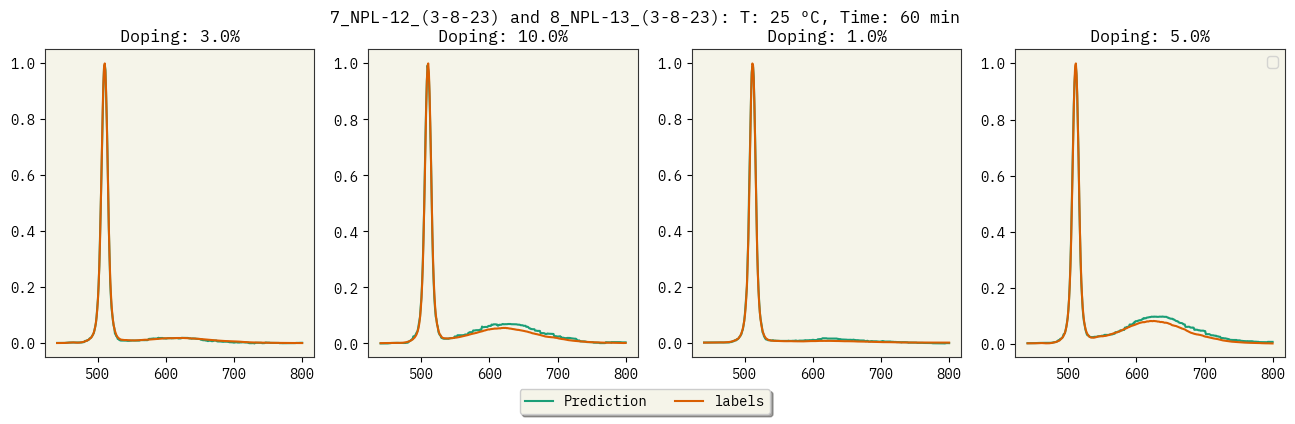

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i=0
for group, predictions in one_out:
    axs = axs.flatten()
    exp, T, d, t = group
    if exp not in ["8_NPL-13_(3-8-23)", "7_NPL-12_(3-8-23)"] or T != 0.0 or t != 60:
        continue
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    title = f"Doping: {d}%"

    if i == 0:
        axs[i].plot(predictions[2], predictions[0], color="C0", label='Prediction')
        axs[i].plot(predictions[2], predictions[1], color="C1", label='labels')
    else:
        axs[i].plot(predictions[2], predictions[0], color="C0")
        axs[i].plot(predictions[2], predictions[1], color="C1")
    axs[i].set_title(title)

    i+=1 
    # plt.savefig(f'preds/{group}.png')
fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
fig.suptitle(f"7_NPL-12_(3-8-23) and 8_NPL-13_(3-8-23): T: 25 ºC, Time: 60 min")
plt.legend()
plt.show()


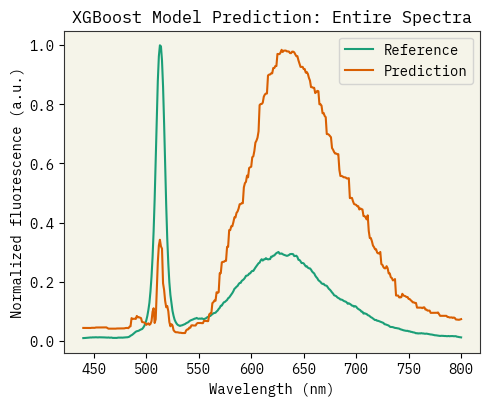

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

i=0
for group, predictions in one_out:
    if i == 0:
        exp, T, d, t = group
        title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
        plt.figure()
        sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
        sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction')
        plt.legend()
        # plt.savefig(f'preds/{group}.png')
        fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
        # plt.title(title)
        plt.title("XGBoost Model Prediction: Entire Spectra")
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized fluorescence (a.u.)")
        plt.tight_layout()
        plt.show()
    i += 1



### Evaluate predictions

In [13]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [14]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

pred_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}
label_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}

for group, predictions in one_out:
    pred_peak = get_peaks(predictions[2], predictions[0])
    pred_norm_area = get_area_under_peaks(predictions[2], predictions[0])
    pred_area = get_area_under_peaks(predictions[2], predictions[0], norm=pred_norm_area)

    label_peak = get_peaks(predictions[2], predictions[1])
    label_norm_area = get_area_under_peaks(predictions[2], predictions[1])
    label_area = get_area_under_peaks(predictions[2], predictions[1], norm=label_norm_area)
    
    pred_dict["Peak1"].append(pred_peak[0])
    pred_dict["Peak2"].append(pred_peak[1])
    pred_dict["Area1"].append(pred_area[0])
    pred_dict["Area2"].append(pred_area[1])
    pred_dict["Distance_peaks"].append(pred_peak[1] - pred_peak[0])

    label_dict["Peak1"].append(label_peak[0])
    label_dict["Peak2"].append(label_peak[1])
    label_dict["Area1"].append(label_area[0])
    label_dict["Area2"].append(label_area[1])
    label_dict["Distance_peaks"].append(label_peak[1] - label_peak[0])
    
    #plot
    # exp, T, d, t = group
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    # plt.figure()
    # sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction').set(title=title)
    # sns.lineplot(x=predictions[2], y=predictions[1], label='label')
    # plt.legend()
    # plt.show()    

for k in pred_dict.keys():
    print(k, rmse(np.array(pred_dict[k]), np.array(label_dict[k])))

Peak1 2.7677995385710803
Peak2 26.792856190730074
Area1 0.183312348486732
Area2 0.15250504094001105
Distance_peaks 27.082216094171994


# bolift

In [9]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

## Predicting peaks

In [4]:
df = pd.read_csv('Data/procedures.tsv', sep="\t")
prompts = df['prompt'].tolist()
peaks1 = df['peak1'].tolist()
peaks2 = df['peak2'].tolist()

import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

In [5]:
asktell1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell1.tell(prompts[i], peaks1[i])

for i in train_indexes:
    asktell2.tell(prompts[i], peaks2[i])

In [7]:
system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat=[]
y=[]
for i in test_indexes:
  yhat1 = asktell1.predict(prompts[i], system_message=system_message)
  yhat2 = asktell2.predict(prompts[i], system_message=system_message)
  print(f"{yhat1.mean():.2f}+/-{yhat1.std():.2f} : {peaks1[i]} // {yhat2.mean():.2f}+/-{yhat2.std():.2f} : {peaks2[i]}")

510.00+/-1.53 : 510.0 // 613.20+/-2.71 : 614.0
511.00+/-1.53 : 512.0 // 639.40+/-5.08 : 650.0
513.00+/-1.53 : 513.0 // 669.20+/-6.85 : 644.0
513.00+/-1.53 : 513.0 // 628.20+/-0.40 : 624.0
514.00+/-1.53 : 514.0 // 619.40+/-2.06 : 626.0
510.00+/-1.53 : 509.0 // 626.00+/-2.97 : 627.0
510.40+/-0.80 : 511.0 // 628.60+/-15.37 : 649.0
510.80+/-0.98 : 491.0 // 646.00+/-1.26 : 654.0
514.00+/-1.53 : 513.0 // 625.00+/-6.57 : 626.0
510.10+/-0.49 : 510.0 // 597.80+/-27.06 : 625.0
511.00+/-1.53 : 511.0 // 610.00+/-7.90 : 609.0
511.00+/-1.53 : 511.0 // 558.40+/-14.14 : 633.0


In [8]:
i=0
for group, predictions in one_out:
    if i == 0:
        exp, T, d, t = group
        title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
        plt.figure()
        sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
        plt.axvline(x = asktell1.predict(prompts[0]).mean(), color = 'C1', linestyle = '--', label = 'Peak1')
        plt.axvline(x = asktell2.predict(prompts[0]).mean(), color = 'C3', linestyle = '--', label = 'Peak2')
        fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
        # plt.title(title)
        plt.title("LLM Prediction: Spectra Metrics")
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized fluorescence (a.u.)")
        plt.tight_layout()
        plt.show()
    i += 1

NameError: name 'one_out' is not defined

## Testing prediction

In [96]:
df = pd.read_csv('Data/procedures_new.tsv', sep="\t")
prompts = df['prompt'].tolist()
labels_f = df['obj_f'].to_list()

In [97]:
import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

In [98]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7,
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
else:
    inv_system_message = ""

for i in train_indexes:
  if labels_f[i] >= 0:
    asktell.tell(prompts[i], labels_f[i])

In [99]:
yhat=[]
y=[]
for i in test_indexes:
  yhat.append(asktell.predict(prompts[i] , system_message=""))
  y.append(labels_f[i]) 

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/maykcaldas/miniconda3/envs/doe/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Using default. 
Not clearly specifying the task for the LLM usually decreases its performance considerably.
  warnings.warn("No system message provided for prediction. Using default. \nNot clearly specifying the task for the LLM usually decreases its performance considerably.")
/Users/maykcaldas/miniconda3/envs/doe/lib/python3.10/site-packages/bolift/asktell.py:488: UserWarning: No system message provided for prediction. Usin

In [ ]:
for i in test_indexes:
  print(f"{prompts[i]} => {labels_f[i]}")

# [f"{i.mean():.2f}" for i in yhat], y

|        predicted        |   label    |     AE     | 
|    0.10   +/-   0.04    |    0.36    |    0.26    |
|    0.11   +/-   0.02    |    0.09    |    0.02    |
|    0.51   +/-   0.18    |    0.18    |    0.33    |
|    0.24   +/-   0.04    |    0.13    |    0.11    |
|    0.10   +/-   0.00    |    0.12    |    0.02    |
|    2.58   +/-   2.25    |    0.00    |    2.58    |
|    2.18   +/-   0.63    |    0.32    |    1.86    |
|    0.72   +/-   0.79    |    0.08    |    0.63    |
|    0.10   +/-   0.07    |    0.31    |    0.20    |
|    5.25   +/-   2.45    |    0.35    |    4.90    |
|    0.06   +/-   0.06    |    0.00    |    0.06    |
|    0.09   +/-   0.13    |    0.03    |    0.06    |

              RMSE: 1.70              


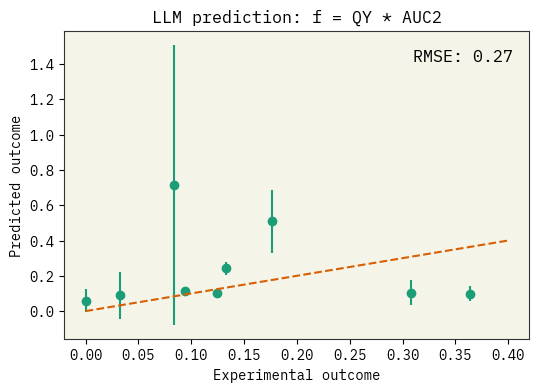

In [115]:
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
  n+=1
  mae = abs(ihat.mean()-i)
  print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
  sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
yhat_mean = [ihat.mean() for ihat in yhat]
y_plot    = np.array(y)[np.where(np.array(yhat_mean) <= 1)]
yhat_plot = np.array(yhat_mean)[np.where(np.array(yhat_mean) <= 1)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(yhat_mean) <= 1)]
plt.figure(figsize=(6, 4))
plt.xlabel('Experimental outcome')
plt.ylabel('Predicted outcome')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('LLM prediction: f = QY * AUC2')
plt.plot((0,0.4), (0,0.4), '--')
plt.text(0.75, 0.90, f"RMSE: {rmse(y_plot, yhat_plot):.2f}", fontsize=12, transform=plt.gca().transAxes)
plt.show()

## Bayesian optimization

In [10]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [11]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

Loaded system message
Loaded inv system message
Pool of 4536 items with 0 selected


/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! logprobs is not default parameter.
                logprobs was transferred to model_kwargs.
                Please confirm that logprobs is what you intended.
  warnings.warn(
/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! logprobs is not default parameter.
                logprobs was transferred to model_kwargs.
                Please confirm that logprobs is what you intended.
  warnings.warn(


Pool of 4536 items with 0 selected


In [12]:
max(labels_f)

0.1721152273629967

In [14]:
selected = asktell.ask(pool, aq_fxn="expected_improvement", k=5, inv_filter=15, aug_random_filter=1, inv_system_message=inv_system_message, system_message=system_message)
i = 0
for prompt, p in zip(selected[0], asktell.predict(selected[0], system_message=system_message)):
    print(f"{prompt} => {p.mean():.4f} +/- {p.std():.4f}\n")
    # print(f"{i+1}: {prompt}")
    i+=1


Stock nanoplatelets have dimensions 28.639 nm by 9.008 nm and the optical density of 100x hexanes dilution of stock is 0.300% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 3.500 mg of silver acetate in 21.397 mL of MeOH and 8.559 mL of water. 2.000 % Ag doping requires 76.264 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes. => 0.4904 +/- 0.4042

Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00070 M is made with 14.000 mg of silver acetate in 85.589 mL of MeOH and 34.236 mL of water. 5.000 % Ag doping requir

In [ ]:
i=0
for prompt in selected[0]:
    print(f"{i+1}: {prompt}\n")
    i+=1

## New exp suggestion

In [12]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [13]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

Loaded system message
Loaded inv system message
Pool of 1944 items with 0 selected
Pool of 1944 items with 0 selected


In [14]:
max(labels_f)

0.1721152273629967

In [22]:
propts = []
preds_mean = []
preds_std = []

for p in pool:
  propts.append(p)
  pred = asktell.predict(p, system_message=system_message)
  preds_mean.append(pred.mean())
  preds_std.append(pred.std())

predicted_pool = pd.DataFrame({
  'prompt': propts, 
  'pred_mean': preds_mean,
  'pred_std': preds_std
  })

In [69]:
predicted_pool.sort_values(by='pred_mean', ascending=True, inplace=True)
predicted_pool.to_csv(f'Data/predicted_pool_{pool_type}.txt', sep=';', index=False)
predicted_pool

,prompt,pred_mean,pred_std
387,Stock nanoplatelets have dimensions 26.577 nm ...,0.01090,0.002800
1141,Stock nanoplatelets have dimensions 35.064 nm ...,0.01600,0.004899
27,Stock nanoplatelets have dimensions 35.064 nm ...,0.02024,0.013807
190,Stock nanoplatelets have dimensions 35.064 nm ...,0.02200,0.004000
780,Stock nanoplatelets have dimensions 26.437 nm ...,0.02400,0.008000
...,...,...,...
61,Stock nanoplatelets have dimensions 35.064 nm ...,132.32530,258.848891
1318,Stock nanoplatelets have dimensions 26.437 nm ...,132.36400,258.830118
888,Stock nanoplatelets have dimensions 26.437 nm ...,260.05600,318.387944
1197,Stock nanoplatelets have dimensions 26.577 nm ...,260.38600,318.118862


In [56]:
filtered_pool = predicted_pool[predicted_pool['pred_mean'] < 0.7]
filtered_pool = filtered_pool[filtered_pool['pred_std'] < 0.1]

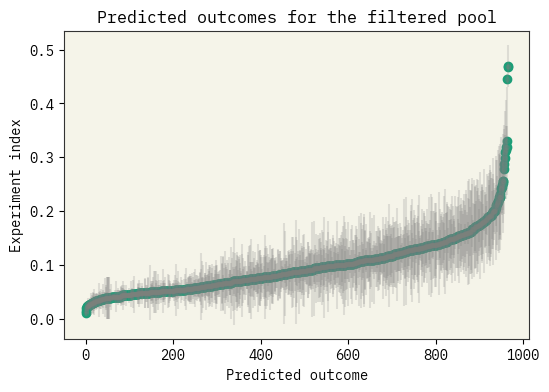

In [57]:
# plot filtered+pool means using pred_std as error
plt.figure(figsize=(6, 4))
plt.errorbar(range(len(filtered_pool)), filtered_pool['pred_mean'],yerr=filtered_pool['pred_std'], fmt='.', alpha=0.2, color='gray')
plt.scatter(range(len(filtered_pool)), filtered_pool['pred_mean'], label='Filtered pool')
plt.xlabel('Predicted outcome')
plt.ylabel('Experiment index')
plt.title('Predicted outcomes for the filtered pool')
plt.show()

In [89]:
for l in [2,4,23, 950,953,947, 965,964,962]:
# for l in range(900, 950):
  print(f''' ------------ [index: {l}] ------------
  prompt: {filtered_pool.iloc[l]['prompt']}
  prediction: {filtered_pool.iloc[l]['pred_mean']} +/- {filtered_pool.iloc[l]['pred_std']}
  ''')

 ------------ [index: 2] ------------
  prompt: Stock nanoplatelets have dimensions 35.064 nm by 8.954 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 3.500 mg of silver acetate in 2.496 mL of MeOH and 0.999 mL of water. 5.000 % Ag doping requires 6.768 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 0.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
  prediction: 0.02024 +/- 0.013806896827310618
  
 ------------ [index: 4] ------------
  prompt: Stock nanoplatelets have dimensions 26.437 nm by 8.291 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of